# Seizure Prediction from EEG Epochs using a hybrid CNN-LTSM model

This notebook runs an analysis that implements a deep learning pipeline for 
classifying seizure vs. non-seizure EEG segments using PyTorch.   
It includes data loading, preprocessing, model definition, training, 
and evaluation.  

All analysis has been run in python 3.12, and data can be found at the following link:  
https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset/data

**Steps are as follows:**  
---------------  
1. **Configuration & Setup**  
   - Defines runtime parameters (e.g., epochs, working directory).  
2. **Data Loading & Normalization**  
   - Loads pre-saved EEG training and validation datasets.  
   - Normalizes each EEG channel to have zero mean and unit variance.  
3. **Data Preparation**  
   - Converts EEG data and labels into PyTorch tensors.  
   - Uses a `WeightedRandomSampler` to balance seizure/non-seizure samples during training.  
4. **Custom Weighted Focal Loss**  
   - Implements a class-weighted focal loss to handle class imbalance and focus learning on difficult seizure examples.  
5. **EEGClassifier Model**  
   - A hybrid CNN–LSTM network with attention pooling:  
     • CNN layers extract spatial EEG features.  
     • LSTM captures temporal dependencies.  
     • Attention mechanism learns which time points are most informative.  
     • Fully connected layers output seizure probability.  
6. **Training Loop**  
   - Iteratively trains the model with Adam optimizer and focal loss.  
   - Monitors F1 score, precision, and recall.  
   - Implements early stopping according to the F1 training score to prevent overfitting.  
7. **Evaluation**  
   - Evaluates the trained model on the validation set.  
   - Reports accuracy, ROC-AUC, F1, precision, recall.  
   - Plots Confusion Matrix, ROC-curve, Precision-Recall Curve, and a probability histogram.

## Initialisation

In [1]:
# Requirments
import numpy as np # 1.26.4 to be compatible with torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                             f1_score, precision_score, recall_score, roc_curve,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
##################################################################
# Configs
##################################################################
os.chdir('/Users/kanepavlovich/Documents/Job Things/Applications/Seer/Assessment/')
num_epochs = 20
gamma=2.5 # Importance of mis-classified examples (1=low importance, 3=high importance)
alpha=0.8 # Defines importance of seizure samples, at 0.8 seizure samples are 4 times more important than non-seizure samples
torch.set_flush_denormal(True)  # Prevent CPU slowdowns from subnormal floats during training

True

In [3]:
##################################################################
# Utils
##################################################################
def normalize_eeg(X):
    """
    Computes a per channel z-score normalisation (zero mean and unit variance) over time.
    X shape: (n_samples, n_channels, n_timepoints)
    """
    mean = X.mean(axis=2, keepdims=True)
    std = X.std(axis=2, keepdims=True) + 1e-6
    return (X - mean) / std

In [4]:
##################################################################
# Load Data
##################################################################
train = np.load('Data/eeg-seizure_train.npz')
X_train = train['train_signals']
y_train = train['train_labels']

test = np.load('Data/eeg-seizure_val.npz', allow_pickle=True)
X_test = test['val_signals']
y_test = test['val_labels']

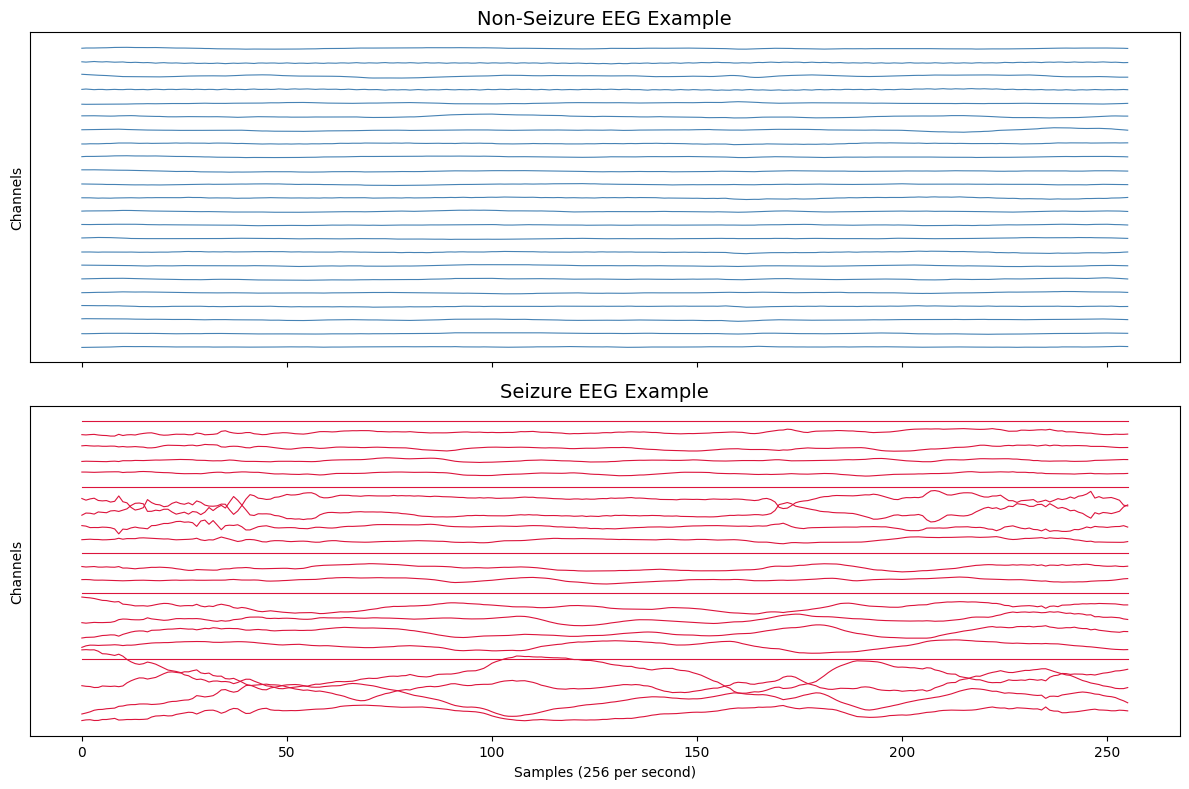

In [5]:
##################################################################
# Inspect Seizure and non-seizure example epoch
##################################################################
np.random.seed(90)  # optional, for reproducibility
seizure_idx = np.random.choice(np.where(y_train == 1)[0])
nonseizure_idx = np.random.choice(np.where(y_train == 0)[0])

seizure_data = X_train[seizure_idx]
nonseizure_data = X_train[nonseizure_idx]
n_channels, n_time = seizure_data.shape
time = np.arange(n_time)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Non-seizure example ---
for ch in range(n_channels):
    axes[0].plot(time, nonseizure_data[ch] + ch*300, color='steelblue', lw=0.8)
axes[0].set_title("Non-Seizure EEG Example", fontsize=14)
axes[0].set_ylabel("Channels")
axes[0].set_yticks([])  
axes[0].set_yticklabels([])  

# --- Seizure example ---
for ch in range(n_channels):
    axes[1].plot(time, seizure_data[ch] + ch*300, color='crimson', lw=0.8)
axes[1].set_title("Seizure EEG Example", fontsize=14)
axes[1].set_xlabel("Samples (256 per second)")
axes[1].set_ylabel("Channels")
axes[1].set_yticks([])  
axes[1].set_yticklabels([])

plt.tight_layout()
plt.show()

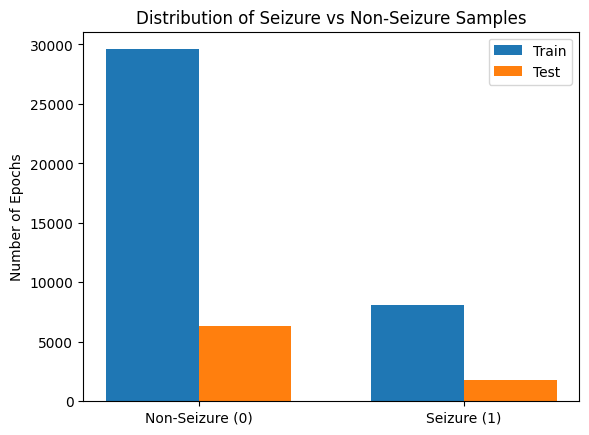

In [6]:
##################################################################
# Plot number of Seizure and non-seizure counts.
##################################################################
train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]

# Plot histogram
labels = ['Non-Seizure (0)', 'Seizure (1)']
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, train_counts, width, label='Train')
plt.bar(x + width/2, test_counts, width, label='Test')

plt.ylabel('Number of Epochs')
plt.title('Distribution of Seizure vs Non-Seizure Samples')
plt.xticks(x, labels)
plt.legend()
plt.show()

**Weighting Procedure**  
The below weighting procedure balances the training data so that seizure and non-seizure samples are sampled more evenly due to the class imbalance seen in the above graph. It first counts how many examples belong to each class, then assigns higher sampling weights to the rarer seizure samples (1/(2*n_seiz)) and lower weights to the abundant non-seizure samples (1/n_non_seiz). These weights are passed to a WeightedRandomSampler, which draws samples with replacement according to their weights.

In [7]:
##################################################################
# Process Data (Normalise) and create tensor datasets
##################################################################
X_train = normalize_eeg(X_train)
X_test = normalize_eeg(X_test)

# Create torch datasets and loaders
# ---- Train data ----
X_full = torch.tensor(X_train, dtype=torch.float32)
y_full = torch.tensor(y_train, dtype=torch.float32)

# Create weighted batches for training. 
n_seiz = (y_full == 1).sum().item()
n_non_seiz = (y_full == 0).sum().item()
weights = torch.where(y_full == 1, 1/(2*n_seiz), 1/n_non_seiz)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

dataset = TensorDataset(X_full, y_full)
clf_loader = DataLoader(dataset, batch_size=64, sampler=sampler)

# ---- Test data ----
X_full_test = torch.tensor(X_test, dtype=torch.float32)
y_full_test = torch.tensor(y_test, dtype=torch.float32)


## Defining the model

**Custom Weighted Loss Function**  
This function is designed to handle class imbalance when distinguishing seizure from non-seizure EEG samples.  
The standard approach of using binary cross-entropy (BCE) can cause the model to become biased toward the over-represented non-seizure class because errors on rare classes have little influence on the overall loss. The focal loss modifies BCE by adding two terms:
  
(1 − pt)ᵞ, which reduces the loss contribution from well-classified examples and focuses learning on harder, misclassified samples. The parameter gamma controls how strongly this focusing effect applies.
  
αₜ, which explicitly weights the loss for each class — here, seizure samples are given more importance (alpha=0.8) to counter their rarity.
  
Together, these adjustments ensure the model pays more attention to underrepresented seizure events and difficult cases, improving its ability to detect seizures despite class imbalance.

In [8]:
##################################################################
# Custom Loss function.
##################################################################
class WeightedFocalLoss(nn.Module):
    def __init__(self, y_true, gamma=3.0, alpha=0.8):
        """
        Weighted Focal Loss for binary classification with imbalance handling.
        Args:
            y_true (Tensor): tensor of all labels in dataset (used to compute class weights)
            gamma (float): focusing parameter
            alpha (float): lower class weighting parameter
        """
        super().__init__()
        self.gamma = gamma
        self.reduction = 'mean'

        # set alpha to a high value to pay importance to seizure samples
        self.alpha = alpha

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.clamp(torch.sigmoid(logits), 1e-4, 1 - 1e-4)
        pt = torch.where(targets == 1, probs, 1 - probs)

        # alpha_t = alpha for seizures, (1 - alpha) for non-seizures
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)

        loss = alpha_t * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

  
**Hybrid CNN-LTSM Model**  
This model is designed to classify EEG time series by combining convolutional, recurrent, and attention-based mechanisms to extract both spatial and temporal information from brain activity.

It begins with a series of 1D convolutional layers that operate across the EEG’s 23 input channels and time points. These layers learn local temporal features (like oscillatory patterns or short bursts of activity), while progressively expanding the feature depth (64 → 128 → 256). The kernel window starts large (at 7) and progressively drops across layers (to 5, then 3) so that the model first captures broad patterns and then focuses on finer details. Each convolution block includes batch normalization (which stabilizes training), ReLU activations (introducing nonlinearity), and dropout (reducing overfitting).
  
Next, the temporal convolution block compresses the feature dimension back down (256 → 128 → 64), emphasizing meaningful features and smoothing over noise. The data is then transposed so that each time point is represented as a feature vector.

Next, the bidirectional LSTM models longer-range dependencies across time, capturing both forward and backward temporal context. It is important in this context, as seizure patterns may emerge gradually or depend on preceding neural activity. The LSTM outputs a sequence of hidden representations that encode temporal dynamics.

To focus the model’s attention on the most informative time periods, an attention mechanism computes a learnable weight for each time step. These weights are normalized via softmax and used to compute a weighted average of all LSTM outputs. This allows the network to emphasize time points most relevant to seizure detection while downplaying irrelevant segments.

Finally, the classifier maps the weighted averages from the attention layer to a single output value representing the probability of a seizure.
  
Below is a schematic of the Neural Network.

<img src="NN_figure.jpg" alt="Neural Network Figure" width="90%">


In [9]:
##################################################################
# Classifier Model. 
##################################################################
class EEGClassifier(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(23, 64, 7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(64, 128, 5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.temporal_conv = nn.Sequential(
            nn.Conv1d(256, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # LSTM keeps temporal structure
        self.temporal_lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)

        # Attention pooling (learns which time points matter)
        self.attn = nn.Sequential(
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # [batch, time, features]
        
        self.temporal_lstm.flatten_parameters()
        x, _ = self.temporal_lstm(x)  # [batch, time, hidden*2]
        
        # Compute attention weights
        attn_scores = self.attn(x)  # [batch, time, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # normalized across time
        context = torch.sum(attn_weights * x, dim=1)  # weighted sum over time
        
        return self.classifier(context)

## Train Model

This section defines and trains the EEG classification model while monitoring its performance to prevent overfitting. First, the classifier is initialized with the Weighted Focal Loss function (explained above) and the Adam optimizer is used to update model parameters, with a small learning rate and L2 regularization to stabilize learning. During training, each epoch iterates through the batches of EEG data, computing predictions, calculating loss, and performing backpropagation to minimize it. After each batch, predictions are stored to compute F1 on the training data. The model is then evaluated on a held-out test set to track generalization performance. An early stopping mechanism halts training if the model shows no improvement in F1 score for a predefined number of epochs (patience = 3), as a safeguard to reduce overfitting.

In [11]:
# Model, loss, optimizer
clf_model = EEGClassifier()
clf_criterion = WeightedFocalLoss(y_true=y_full, gamma=gamma, alpha=alpha)
clf_optimizer = optim.Adam(clf_model.parameters(), lr=1e-3, weight_decay=1e-4)

best_f1 = 0
epochs_no_improve = 0
patience = 3  # stop after 3 epochs with no improvement
loss_collated = []
train_f1_collated = []
# Training loop
for epoch in range(num_epochs):

    # ---- TRAINING ----
    clf_model.train()
    total_loss = 0
    all_y_true_train = []
    all_y_pred_train = []

    for X_batch, y_batch in tqdm(clf_loader, desc=f"[Classifier] Epoch {epoch+1}/{num_epochs}"):
        clf_optimizer.zero_grad()
        pred = clf_model(X_batch).squeeze()
        loss = clf_criterion(pred, y_batch)
        loss.backward()
        clf_optimizer.step()
        total_loss += loss.item()
        loss_collated.append(loss)
        # store predictions for F1 on training data
        preds = (pred.detach().numpy() > 0.5).astype(int)
        all_y_true_train.extend(y_batch.numpy())
        all_y_pred_train.extend(preds)

    # Compute F1 on training set
    train_f1 = f1_score(all_y_true_train, all_y_pred_train)
    train_f1_collated.append(train_f1)
    train_precision = precision_score(all_y_true_train, all_y_pred_train)
    train_recall = recall_score(all_y_true_train, all_y_pred_train)

    # ---- EVALUATION ----
    clf_model.eval()
    with torch.no_grad():
        y_pred = clf_model(X_full_test).squeeze()

    y_pred_np = y_pred.numpy()
    y_true_np = y_full_test.numpy()
    y_pred_class = (y_pred_np > 0.5).astype(int)
    test_f1 = f1_score(y_true_np, y_pred_class)
    test_precision = precision_score(y_true_np, y_pred_class)
    test_recall = recall_score(y_true_np, y_pred_class)

    print(f"[Classifier] Epoch {epoch+1} | "
          f"Train Loss={total_loss/len(clf_loader):.4f} | "
          f"Train F1={train_f1:.4f} | Test F1={test_f1:.4f} | "
          f"Precision={test_precision:.4f} | Recall={test_recall:.4f}")

    # ---- EARLY STOPPING -----
    if train_f1 > best_f1:
        best_f1 = train_f1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1} (no F1 improvement for {patience} epochs)")
            break

[Classifier] Epoch 1/20: 100%|████████████████| 589/589 [03:45<00:00,  2.61it/s]


[Classifier] Epoch 1 | Train Loss=0.0306 | Train F1=0.6781 | Test F1=0.5445 | Precision=0.3795 | Recall=0.9633


[Classifier] Epoch 2/20: 100%|████████████████| 589/589 [03:34<00:00,  2.74it/s]


[Classifier] Epoch 2 | Train Loss=0.0259 | Train F1=0.7482 | Test F1=0.6738 | Precision=0.7673 | Recall=0.6007


[Classifier] Epoch 3/20: 100%|████████████████| 589/589 [03:32<00:00,  2.78it/s]


[Classifier] Epoch 3 | Train Loss=0.0236 | Train F1=0.7778 | Test F1=0.6975 | Precision=0.5792 | Recall=0.8765


[Classifier] Epoch 4/20: 100%|████████████████| 589/589 [03:24<00:00,  2.89it/s]


[Classifier] Epoch 4 | Train Loss=0.0222 | Train F1=0.7961 | Test F1=0.7557 | Precision=0.7733 | Recall=0.7389


[Classifier] Epoch 5/20: 100%|████████████████| 589/589 [03:30<00:00,  2.80it/s]


[Classifier] Epoch 5 | Train Loss=0.0209 | Train F1=0.8088 | Test F1=0.5407 | Precision=0.9129 | Recall=0.3841


[Classifier] Epoch 6/20: 100%|████████████████| 589/589 [03:20<00:00,  2.93it/s]


[Classifier] Epoch 6 | Train Loss=0.0198 | Train F1=0.8249 | Test F1=0.7314 | Precision=0.8068 | Recall=0.6689


[Classifier] Epoch 7/20: 100%|████████████████| 589/589 [03:25<00:00,  2.87it/s]


[Classifier] Epoch 7 | Train Loss=0.0186 | Train F1=0.8334 | Test F1=0.7751 | Precision=0.7054 | Recall=0.8601


[Classifier] Epoch 8/20: 100%|████████████████| 589/589 [03:27<00:00,  2.84it/s]


[Classifier] Epoch 8 | Train Loss=0.0183 | Train F1=0.8362 | Test F1=0.7515 | Precision=0.8828 | Recall=0.6543


[Classifier] Epoch 9/20: 100%|████████████████| 589/589 [03:27<00:00,  2.84it/s]


[Classifier] Epoch 9 | Train Loss=0.0179 | Train F1=0.8376 | Test F1=0.7678 | Precision=0.6675 | Recall=0.9036


[Classifier] Epoch 10/20: 100%|███████████████| 589/589 [03:28<00:00,  2.83it/s]


[Classifier] Epoch 10 | Train Loss=0.0176 | Train F1=0.8445 | Test F1=0.7931 | Precision=0.7270 | Recall=0.8725


[Classifier] Epoch 11/20: 100%|███████████████| 589/589 [03:23<00:00,  2.89it/s]


[Classifier] Epoch 11 | Train Loss=0.0167 | Train F1=0.8525 | Test F1=0.7963 | Precision=0.7499 | Recall=0.8488


[Classifier] Epoch 12/20: 100%|███████████████| 589/589 [03:22<00:00,  2.91it/s]


[Classifier] Epoch 12 | Train Loss=0.0165 | Train F1=0.8566 | Test F1=0.7964 | Precision=0.7278 | Recall=0.8793


[Classifier] Epoch 13/20: 100%|███████████████| 589/589 [03:20<00:00,  2.94it/s]


[Classifier] Epoch 13 | Train Loss=0.0160 | Train F1=0.8616 | Test F1=0.7741 | Precision=0.6682 | Recall=0.9199


[Classifier] Epoch 14/20: 100%|███████████████| 589/589 [03:25<00:00,  2.86it/s]


[Classifier] Epoch 14 | Train Loss=0.0157 | Train F1=0.8668 | Test F1=0.7801 | Precision=0.6796 | Recall=0.9154


[Classifier] Epoch 15/20: 100%|███████████████| 589/589 [03:23<00:00,  2.89it/s]


[Classifier] Epoch 15 | Train Loss=0.0157 | Train F1=0.8662 | Test F1=0.8083 | Precision=0.7714 | Recall=0.8488


[Classifier] Epoch 16/20: 100%|███████████████| 589/589 [03:27<00:00,  2.84it/s]


[Classifier] Epoch 16 | Train Loss=0.0151 | Train F1=0.8689 | Test F1=0.7947 | Precision=0.7131 | Recall=0.8973


[Classifier] Epoch 17/20: 100%|███████████████| 589/589 [03:34<00:00,  2.75it/s]


[Classifier] Epoch 17 | Train Loss=0.0152 | Train F1=0.8697 | Test F1=0.7927 | Precision=0.7086 | Recall=0.8996


[Classifier] Epoch 18/20: 100%|███████████████| 589/589 [03:34<00:00,  2.75it/s]


[Classifier] Epoch 18 | Train Loss=0.0152 | Train F1=0.8720 | Test F1=0.8171 | Precision=0.7728 | Recall=0.8669


[Classifier] Epoch 19/20: 100%|███████████████| 589/589 [03:32<00:00,  2.78it/s]


[Classifier] Epoch 19 | Train Loss=0.0151 | Train F1=0.8695 | Test F1=0.8059 | Precision=0.7568 | Recall=0.8618


[Classifier] Epoch 20/20: 100%|███████████████| 589/589 [03:34<00:00,  2.74it/s]


[Classifier] Epoch 20 | Train Loss=0.0143 | Train F1=0.8756 | Test F1=0.8026 | Precision=0.7279 | Recall=0.8945


## Evaluate Model on held out test set

In [20]:
# ----- Classification Evaluation -----
clf_model.eval()
with torch.no_grad():
    y_pred = clf_model(X_full_test).squeeze()

y_pred_np = y_pred.numpy()
y_true_np = y_full_test.numpy()
y_pred_class = (y_pred_np > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_true_np, y_pred_class)
f1 = f1_score(y_true_np, y_pred_class)
precision = precision_score(y_true_np, y_pred_class)
recall = recall_score(y_true_np, y_pred_class)
auc = roc_auc_score(y_true_np, y_pred_np)
cm = confusion_matrix(y_true_np, y_pred_class)

print("Classification Model Evaluation")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(cm)

Classification Model Evaluation
Accuracy: 0.9034
ROC-AUC: 0.9658
F1 Score: 0.8026
Precision: 0.7279
Recall: 0.8945
Confusion Matrix:
[[5705  593]
 [ 187 1586]]


## Plot results

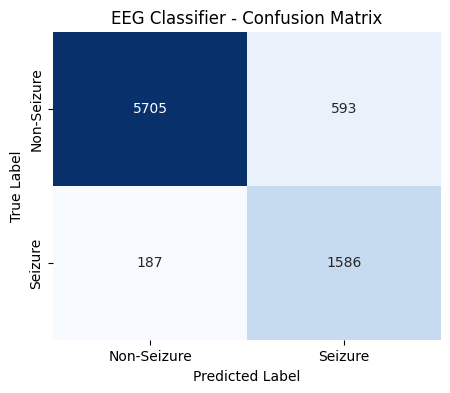

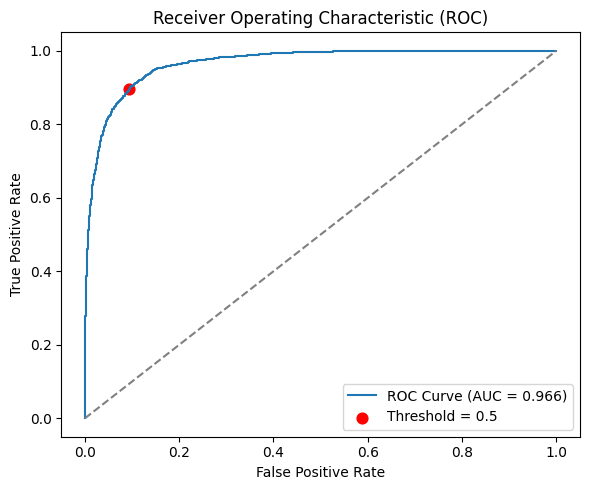

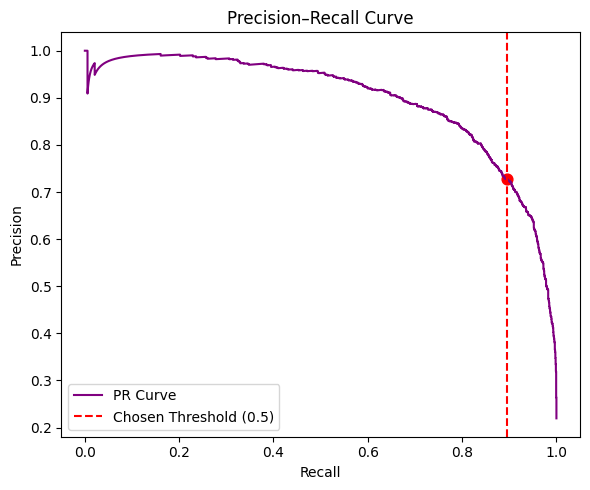

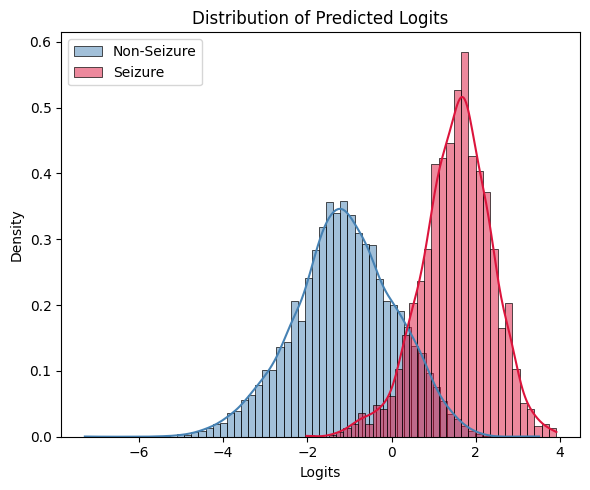

In [25]:
# ---- Plot confusion matrix -----
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Seizure', 'Seizure'],
            yticklabels=['Non-Seizure', 'Seizure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('EEG Classifier - Confusion Matrix')
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_true_np, y_pred_np)
roc_auc = roc_auc_score(y_true_np, y_pred_np)
chosen_threshold = 0.5
closest_idx = np.argmin(np.abs(thresholds - chosen_threshold))
chosen_fpr = fpr[closest_idx]
chosen_tpr = tpr[closest_idx]
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# Mark chosen threshold
plt.scatter(chosen_fpr, chosen_tpr, color='red', s=60, label=f'Threshold = {chosen_threshold}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Precision–Recall Curve ---
precisions, recalls, thresholds = precision_recall_curve(y_true_np, y_pred_np)
chosen_threshold = 0.5
# Find the closest point to the chosen threshold
closest_idx = np.argmin(np.abs(thresholds - chosen_threshold))
chosen_prec = precisions[closest_idx]
chosen_rec = recalls[closest_idx]
# Plot PR curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color='purple', label='PR Curve')
plt.axvline(x=chosen_rec, color='red', linestyle='--', label='Chosen Threshold (0.5)')
plt.scatter(chosen_rec, chosen_prec, color='red', s=60)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


# --- Probability Histogram ---
plt.figure(figsize=(6, 5))
sns.histplot(y_pred_np[y_true_np == 0], color='steelblue', label='Non-Seizure', kde=True, stat="density")
sns.histplot(y_pred_np[y_true_np == 1], color='crimson', label='Seizure', kde=True, stat="density")
plt.xlabel("Logits")
plt.ylabel("Density")
plt.title("Distribution of Predicted Logits")
plt.legend()
plt.tight_layout()
plt.show()


## Summary

This notebook employs a hybrid CNN-LSTM architecture to predict seizures from short EEG epochs.

On our held-out test set, the model achieves 90% accuracy when distinguishing seizure from non-seizure activity.
We observe a strong AUC-ROC score of 0.967, indicating excellent separability, and an F1 score of 0.80, reflecting good balance between sensitivity and precision.

Within the F1 score, the model attains a recall of 0.89 and a precision of 0.73. This means the model is more likely to identify true seizures (high recall) even if that comes at the cost of occasionally predicting a seizure when there isn’t one (lower precision). In practical terms, the model tends to favour sensitivity by capturing as many seizure events as possible. This is typically desirable in clinical or safety-critical applications where missing a seizure is more harmful than raising a false alarm.